###  1. 기상청 데이타 준비


+ https://data.kma.go.kr  >  데이터 > 기상관측 > 지상 >  종관기상관측(ASOS)

    - 자료형태 : 일 자료
    - 날짜 : 10년 데이타 : 2010 01 01 ~ 2019 12 31
    - 지점 : 서울
    - 기온 : 평균 기온
    
    
+ weather 폴더 안에 'raw.csv' 파일로 저장    

### 2. 데이타 정리

+ raw.csv 파일을 읽어서 아래와 같이 가공하여 data.csv 파일로 저장


        연,월,일,기온,품질,균질
        2006,1,1,3.6,8,1
        2006,1,2,4,8,1
        2006,1,3,3.7,8,1
        2006,1,4,4,8,1
        2006,1,5,3.6,8,1
        2006,1,6,2.1,8,1
        ....
       
        [주의] 
        기존에 생성된 csv 파일이 EUC-KR인 경우가 많기에 문자셋 지정한다.
        그러나 저장하는 data.csv 파일은 UTF-8로 문자셋을 지정하여 저장한다.

In [ ]:
in_file = "../data/weather/raw.csv"
out_file = "../data/weather/data.csv"

# CSV 파일을 한 줄 씩 읽어 들이기 ---(*1)
with open(in_file, "rt", encoding="EUC_KR") as fr:
    lines = fr.readlines()
print(type(lines))
print(lines[:5])
    
# 기존의 데이터를 분리해서 가공하기 ---(*2)
#       - 기존 데이타에서 5줄을 버리고 앞에 ["연,월,일,기온,품질,균질\n"] 붙이고자
lines = ["연,월,일,기온,품질,균질\n"] + lines[5:]
print(lines[:2])


#       - /를 , 으로 변경
#       map( function, list ) :  list 각각의 요소에 함수를 적용
lines = map(lambda v: v.replace('/', ','), lines)
print(type(lines))  # : 여기서 lines은 map 객체임

# "".join(lines) : map 객체를 str 형태로
# strip()은 문자열을 처음과 끝에있는 공백문자를 제거
result = "".join(lines).strip()
# print(result)


# 결과를 파일에 출력하기 ---(*3)
with open(out_file, "wt", encoding="utf-8") as fw:
    fw.write(result)
    print("saved.")


### 3.  학습 데이타와 테스트 데이타 만들기 

+ 예를 들어 2010년부터 2019년 데이타까지 있다면


        2006년~2015년 데이타는 학습데이타로
        2016년 데이타는 테스트데이타로 





+ 과거 6일의 데이터를 기반으로 학습할 데이터 만들기

        예를 들어 현재 7일이라면 앞에 1일부터 6일까지는 학습데이타(X)가 되고 7일 데이타는 라벨(Y)가 된다.

In [2]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 기온 데이터 읽어 들이기
df = pd.read_csv('../data/weather/data.csv', encoding="utf-8")

# 데이터를 학습 전용과 테스트 전용으로 분리하기
train_year = (df["연"] <= 2015)
test_year = (df["연"] >= 2016)
interval = 6

# 과거 6일의 데이터를 기반으로 학습할 데이터 만들기 
def make_data(data):
    x = [] # 학습 데이터
    y = [] # 결과
    temps = list(data["기온"])

    # 어렵게 구현했네
    for i in range(len(temps)):
        if i < interval:  continue
        y.append(temps[i])
        xa = []
        for p in range(interval):
            d = i + p - interval
            xa.append(temps[d])
        x.append(xa)
    return (x, y)

train_x, train_y = make_data(df[train_year])
test_x, test_y = make_data(df[test_year])

### 4. 선형 회귀 분석하기 ( LinearRegression )을 이용하여 예측하기

학습 후 예측값 (pre_y) 지정

In [8]:
# 모델에 의해 학습
train_lr = LinearRegression().fit(train_x,train_y)

pre_y = train_lr.predict(test_x)


In [9]:
result_train = train_lr.score(train_x,train_y)
result_test = train_lr.score(test_x,test_y)
print('훈련 데이터 점수 : {:.2f}'.format(result_train))
print('테스트 데이터 점수 : {:.2f}'.format(result_test))

훈련 데이터 점수 : 0.94
테스트 데이터 점수 : 0.92


In [ ]:
# [참고] 검증하기
# print('훈련 세트점수 : {:.2f}'.format( lr.score(train_x, train_y)))
# print('테스트 세트점수 : {:.2f}'.format( lr.score(test_x, test_y)))

### 5. 결과를 그래프로 그리기 

결과(test_y)와 예측(pre_y)을 그래프로 표현하기

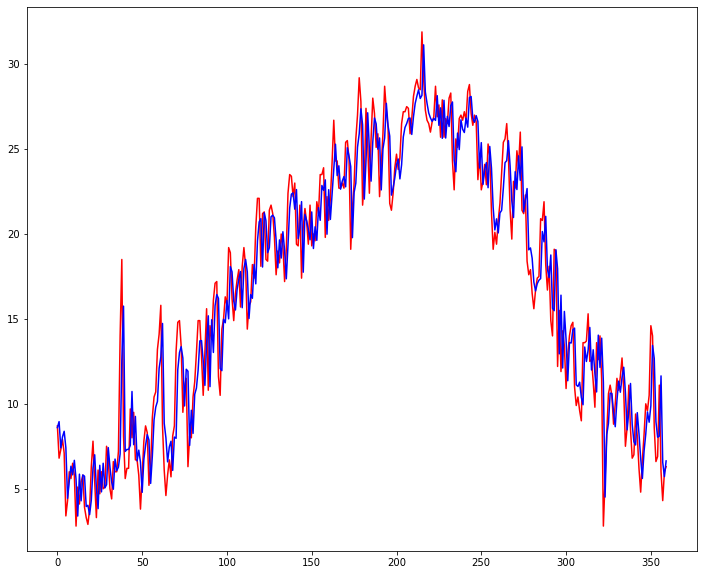

In [12]:
plt.figure(figsize=(12,10))
plt.plot(test_y, c='red')
plt.plot(pre_y, c='blue')


### 6. 결과 평가하기

예측 기온과 실제 기온의 차이를 구해서 확인

pre_y - test_y

예측과 실제 차이의 평균과 최대 오차값을 구해서 확인한다

아래 결과를 확인하면 예측과 실제 차이의 평균은 1.66도 정도이고 최대 오차값은 8.47 정도이다

In [19]:
diff_y = abs(pre_y - test_y)
# print('평균 차이 :',sum(diff_y)/len(diff_y))
print('평균 차이 :',diff_y.mean())
print('최고 차이 :',max(diff_y))

평균 차이 : 1.664068497195426
최고 차이 : 8.471949619908472


[참고도서] 파이썬을 이용한 머신러닝, 딥러닝 실전 앱 개발 (위키북스) 